In [15]:
import pandas as pd
import numpy as np
from geopy.distance import geodesic 
import matplotlib.pyplot as plt
import math
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [16]:
data = pd.read_csv('data.csv')
data.sample(n=5)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
19020,3630020150,20150310T000000,425000.0,3,2.50,1480,1386,3.0,0,0,...,8,1480,0,2005,0,98029,47.5468,-121.998,1470,1593
2852,7202331220,20140721T000000,635000.0,6,2.50,3880,5700,2.0,0,0,...,7,3880,0,2003,0,98053,47.6816,-122.038,2620,5070
1567,1545804460,20150401T000000,294000.0,3,1.75,1530,9362,1.0,0,0,...,7,1530,0,1987,0,98038,47.3643,-122.049,1480,8125
18451,293800900,20141006T000000,829950.0,4,2.50,3430,42775,2.0,0,0,...,10,3430,0,1992,0,98077,47.7650,-122.045,3190,36820
14055,369000365,20150422T000000,510000.0,1,1.00,680,6600,1.0,0,0,...,5,480,200,1916,0,98199,47.6567,-122.392,1170,5500


# Удалим столбцы, с которыми не планируем работать и обработаем некоторые выбросы

In [17]:
data = data.drop(['id','zipcode','lat','long', 'waterfront', 'grade', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15', 'view', 'condition'], axis=1)

In [18]:
data.loc[data['yr_renovated'] == 0, ['yr_renovated']] = data['yr_built']
data['yr_built'] = data['date'].str[0:4].astype(int) - data['yr_built']
data['yr_renovated'] = data['date'].str[0:4].astype(int) - data['yr_renovated']
data = data.drop('date', axis=1)
data.sample(n=5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated
20632,580000.0,3,2.75,1430,1521,2.0,5,5
9906,192500.0,3,1.75,1420,7205,1.0,28,28
3358,304000.0,3,2.50,1710,6773,2.0,22,22
2064,550000.0,3,2.50,1900,3255,2.0,26,14
17253,387500.0,4,1.00,1370,7140,2.0,73,73


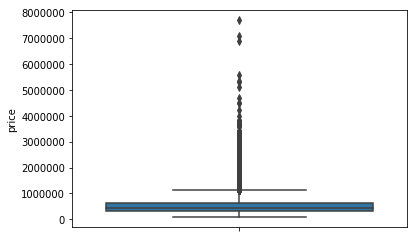

In [19]:
sns.boxplot(y='price', data=data)

In [20]:
data = data[data['price'] <= 1965000] #удалили очень дорогие дома
data = data[(data['bedrooms'] != 0) & (data['bathrooms'] != 0) & (data['bedrooms'] < 10)] #удалили дома без спален и ванных комнат, а еще странный дом с 33 спальнями

# Переведем все в метрическую систему

In [21]:
data.sample(n=5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated
10831,819000.0,3,2.75,3176,13391,2.0,29,29
6557,121800.0,2,1.00,940,8384,1.0,67,67
19706,675000.0,3,3.25,1720,1330,2.0,10,10
19895,1330000.0,4,3.50,3440,9776,2.0,9,9
8079,522500.0,4,2.75,2200,122403,1.5,44,44


In [22]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21376 entries, 0 to 21612
Data columns (total 8 columns):
price           21376 non-null float64
bedrooms        21376 non-null int64
bathrooms       21376 non-null float64
sqft_living     21376 non-null int64
sqft_lot        21376 non-null int64
floors          21376 non-null float64
yr_built        21376 non-null int64
yr_renovated    21376 non-null int64
dtypes: float64(3), int64(5)
memory usage: 1.5 MB


In [23]:
data['sqft_living'] = data['sqft_living'] / 0.093
data['sqft_lot'] = data['sqft_lot'] / 0.093
data['price'] = data['price'] * 72.64

In [24]:
data.sample(n=5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,yr_built,yr_renovated
18840,37627520.0,3,1.00,13655.913978,71096.774194,1.5,88,88
19171,29056000.0,3,1.00,11397.849462,136451.612903,1.0,45,45
350,21719360.0,1,0.75,6021.505376,130322.580645,1.0,47,47
13815,12203520.0,2,1.50,13118.279570,38365.591398,1.5,38,38
18821,30436160.0,3,2.25,18924.731183,176537.634409,1.0,25,25


In [25]:
data.rename(columns={'sqft_living' : 'living_square', 'sqft_lot' : 'total_square'}, inplace=True)
data.sample(n=5)

,price,bedrooms,bathrooms,living_square,total_square,floors,yr_built,yr_renovated
15447,18668480.0,2,1.00,8279.569892,119182.795699,1.0,68,68
9043,33051200.0,5,2.50,24086.021505,83548.387097,1.0,36,36
8915,25424000.0,3,1.75,14838.709677,49354.838710,1.0,64,64
360,33632320.0,3,2.50,17634.408602,322258.064516,2.0,22,22
4338,27603200.0,3,2.25,17204.301075,428473.118280,1.0,56,56


In [26]:
data.to_csv('processed_data.csv', index=False)